In [1]:
import matplotlib.pyplot as plt
from scipy.stats import false_discovery_control
from riskyneuroarousal.utils.load_data import load_behavioral_data
%load_ext rpy2.ipython

##### Load the data
Remove RT outliers (defined as any response time less than 0.2 seconds). This also eliminates the trials where the subject did not respond.

In [2]:
data = load_behavioral_data(min_RT = 0.2)

In [6]:
shared_gain = [10, 12, 14, 16, 18, 20]

In [7]:
x = data.query("gain in @shared_gain").groupby(['sub', 'condition'])["accept"].mean().reset_index()

In [8]:
x.groupby("condition")["accept"].mean()

condition
equalIndifference    0.371939
equalRange           0.576654
Name: accept, dtype: float64

### Analysis of acceptance rate
**Question: Association of Gain and Loss on Acceptance Rate. Differences between conditions**

In [14]:
%%R -i data
library(lme4)
library(lmerTest)
library(broom.mixed)

In [10]:
%%R
model1 <- glmer(accept ~ condition*gain + condition*loss + (1|sub) + (-1+gain|sub) + (-1 +loss|sub) + (-1 + condition|sub), data=data, family=binomial)
summary(model1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: accept ~ condition * gain + condition * loss + (1 | sub) + (-1 +  
    gain | sub) + (-1 + loss | sub) + (-1 + condition | sub)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 12904.4  13003.0  -6440.2  12880.4    27431 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-148.625   -0.137    0.002    0.158  240.134 

Random effects:
 Groups Name                       Variance Std.Dev. Corr 
 sub    (Intercept)                2.80186  1.6739        
 sub.1  gain                       0.09752  0.3123        
 sub.2  loss                       0.09561  0.3092        
 sub.3  conditionequalIndifference 0.47059  0.6860        
        conditionequalRange        2.28295  1.5109   -0.37
Number of obs: 27443, groups:  sub, 108

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -0.

From this, we know that there is a significant difference in how gains and loss influence the acceptance rate per condition. Now lets run a post-hoc analysis to determine the parameters for each condition. 

In [18]:
%%R
modelIndifference <- glmer(accept ~ gain + loss + (1|sub) + (-1+gain|sub) + (-1 +loss|sub), data=data[data$condition == 'equalIndifference', ], family=binomial)
modelRange <- glmer(accept ~ gain + loss + (1|sub) + (-1+gain|sub) + (-1 +loss|sub), data=data[data$condition == 'equalRange', ], family=binomial)

In [28]:
%%R -o results
resultsIndifference <- tidy(modelIndifference, effects = "fixed", conf.int = TRUE, exponentiate = TRUE, conf.level = 0.95) 
resultsRange <- tidy(modelRange, effects = "fixed", conf.int = TRUE, exponentiate = TRUE, conf.level = 0.95)
resultsIndifference$condition <- 'equalIndifference'
resultsRange$condition <- 'equalRange'
results <- rbind(resultsIndifference, resultsRange)

In [29]:
results["p.value"]= false_discovery_control(results["p.value"].values, method="by")
results["significant"] = results["p.value"] < 0.05
results = results.rename(columns={"estimate": "Odds Ratio", "conf.low": "2.5%", "conf.high": "97.5%"})
names = []
for idx, row in results.iterrows():
    if row.term == "(Intercept)":
        names.append(f"Intercept: {row.condition}")
    elif row.term == "gain":
        names.append(f"Gain: {row.condition}")
    elif row.term == "loss":
        names.append(f"Loss: {row.condition}")
results["term"] = names

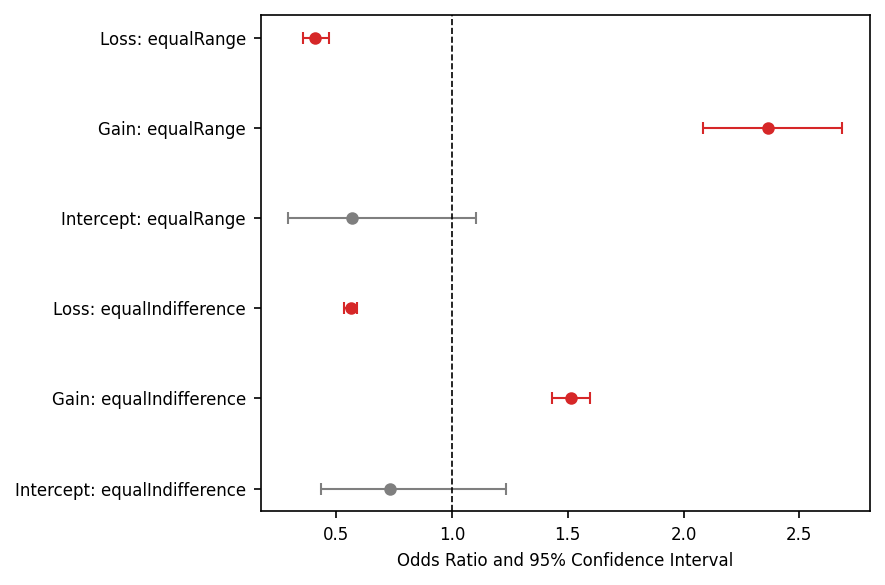

In [30]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
for idx, row in results.iterrows():
    ci = [[row['Odds Ratio'] - row[::-1]['2.5%']], [row['97.5%'] - row['Odds Ratio']]]
    if row['significant']:
        plt.errorbar(x=[row['Odds Ratio']], y=[row.term], xerr=ci,
            ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red")
    else:
        plt.errorbar(x=[row['Odds Ratio']], y=[row.term], xerr=ci,
            ecolor='tab:gray', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:gray", mec="tab:gray")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()